# XGB-LSTM 用于预测

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sqlalchemy import create_engine
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBRegressor
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

## 导入数据

In [4]:
# load data
url = '../dataset_0101110000.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## 归一化

In [13]:
# 归一化
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    normalized_data = MinMaxScaler().fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[['load']])
    return normalized_data, scaler_y

## 特征选择

In [5]:
# 选择重要特征
def select_feature(X, feature_num=10):
    """
    X: features, size * 48 * features
    Y: labels, size *  1
    feature_num: num of selected features
    return: index of selected features
    """
    x = X[:, :-1]
    y = X[:, -1:]
    model = XGBRegressor()
    model.fit(x, y)
    model.importance_type = 'weight'
    ind = (-model.feature_importances_).argsort()[0:feature_num]
    ind = np.append(ind, -1)
    return X[:, ind]

## 构建监督数据集

In [15]:
def Series_To_Supervise(data, seq_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
#     pdb.set_trace()
    dim_0 = data.shape[0] - seq_len
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = data[i: i+seq_len]
        y[i] = data[i+seq_len, y_col_index]
    print("Supervised Train Data: Shape of x: {}, Shape of y: {}".format(x.shape, y.shape))
    return x, y

def Series_To_Supervise_Test(data, seq_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = int((data.shape[0] - seq_len)/24)+1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, 24))
    for i in range(0, dim_0):
        x[i] = data[i*24: i*24+seq_len]
        y[i] = data[i*24+seq_len-24:i*24+seq_len, y_col_index]
    print("Supervised Test Data: Shape of x: {}, Shape of y: {}".format(x.shape, y.shape))
    return x, y

## 五折交叉验证

In [6]:
# 5-fold cross-validation
def split_dataset(X, Y, n_split=5):
    """
    X: original feature, size * 72 * features
    Y: labels, size * 1
    return: list of train_x, test_x, train_y, test_y
    """
    kf = KFold(n_splits=n_split, shuffle=True, random_state=1)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in kf.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, valid_x_list, train_y_list, valid_y_list

## 定义模型

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        # 初始化hidden_state参数
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # 定义层
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 30),
            nn.ReLU(),
            nn.Linear(30,1)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        
        lstm_out, hidden = self.lstm(x, hidden)
        # lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = lstm_out[:, -1, :]
        
        out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        out = self.relu(out)
        
        out = out.view(batch_size, -1)
        out = out[:, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                      torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

## 训练模型

In [8]:
# train the model
def Train_Model(train_x_list, train_y_list, valid_x_list, valid_y_list, hidden_dim, lr, number_epochs=50, batch_size=512,
                input_dim=5, n_layers=2, output_size=1, seq_len=48):
    model_lstm = LSTM(input_dim, output_size, hidden_dim, n_layers)
    model_lstm.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=lr)
    valid_loss_min = np.Inf

    for i in range(5):
        print('train dataset {}'.format(i))
        train_x = train_x_list[i]
        train_y = train_y_list[i]
        valid_x = valid_x_list[i]
        valid_y = valid_y_list[i]
        train_x = train_x[:, 0:seq_len]
        valid_x = valid_x[:, 0:seq_len]
        train_dataset = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
        train_losses = list()
        
        num_without_imp = 0
        
        # train
        for epoch in range(1, number_epochs+1):
            loop = tqdm(enumerate(train_loader), total=len(train_loader))
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                optimizer.zero_grad()
                outputs, hidden = model_lstm(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
                
                if i % 5 == 0:
                    # if num_without_imp > 60:
                    #     return model_lstm
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model_lstm.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device=device)
                        lab = lab.to(device=device)
                        out, h = model_lstm(inp)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())
                    model_lstm.train()
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epochs))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model_lstm.state_dict(), "lstm_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
    return model_lstm

## 测试模型

In [9]:
## test the model 24 hours ahead
def Test_Model_24(model, test_x, test_y, batch_size, seq_len, y_col_index, scaler):
    test_dataset = TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    model.load_state_dict(torch.load('lstm_state_dict.pt'))
    size = 24
    y_pred = list()
    y_true = list()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device=device)
            for i in range(size):
                inp = inputs[:, 0:i+seq_len]
                outputs, hidden = model(inp)
                labels = inputs[:, i+seq_len, y_col_index]                
                y_pred = y_pred + outputs.cpu().numpy().tolist()
                y_true = y_true + labels.cpu().numpy().tolist()
                inputs[:, i+seq_len, y_col_index] = outputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    load_true = scaler.inverse_transform(np.expand_dims(y_true, axis=1))
    load_pred = scaler.inverse_transform(np.expand_dims(y_pred, axis=1))
    MAPE = np.mean(np.abs(load_true-load_pred)/load_true)
    MAE = np.mean(np.abs(load_true-load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true-load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## 定义超参数

In [10]:
# model configs
def Model_Configs():
    batch_sizes = [512]
    n_layers = [4]
    lrs = [0.01]
    hidden_dims = [100]
    configs = list()
    for i in batch_sizes:
        for j in n_layers:
            for k in lrs:
                for l in hidden_dims:
                    configs.append([i, j, k, l])
    return configs

## 定义主函数

In [11]:
def main(n_split=5, seq_len=48, number_epoch=40):
    # normalized_data, scaler_y = normalization(data)
    # y_index = normalized_data.shape[1] - 1
    # num_features = normalized_data.shape[1]
    # x, _ = Series_To_Supervise(normalized_data, seq_len=seq_len + 24, y_col_index=y_index)
    # _, y = Series_To_Supervise(normalized_data, seq_len=seq_len, y_col_index=y_index)
    # y = y[0:-24]
    # train_x_list, valid_x_list, test_x_list, train_y_list, valid_y_list, test_y_list = split_dataset(x, y, n_split=n_split)  
    # 归一化
    normalized_data, scaler_y = normalization(data)
    normalized_data = select_feature(normalized_data, feature_num=15)
    train_data = normalized_data
    test_data = normalized_data[-3000:]
    # 数据处理，将时间序列数据变为监督学习数据
    y_index = normalized_data.shape[1] -1
    num_features = normalized_data.shape[1]
    _, Y = Series_To_Supervise(train_data, seq_len=seq_len, y_col_index=y_index) 
    # 五折交叉验证，划分数据集
    # 为了方便测试24点准确性， seq_len需要+24
    X, _ = Series_To_Supervise(train_data, seq_len=seq_len + 24, y_col_index=y_index)
    Y = Y[:-24]
    train_x_list, valid_x_list, train_y_list, valid_y_list = split_dataset(X, Y)
    test_x, test_y = Series_To_Supervise_Test(test_data, seq_len=seq_len + 24, y_col_index=y_index)  
    
    configs = Model_Configs()
    MAPE_list = list()
    MAE_list = list()
    RMSE_list = list()
    for config in configs:
        batch_size = config[0]
        n_layer = config[1]
        lr = config[2]
        hidden_dim = config[3]
        print("Model Config: batch_size--{}, n_layer--{}, lr--{}, hidden_dims--{}".format(batch_size, n_layer, lr, hidden_dim))
      
        while(1):
            model = Train_Model(train_x_list, train_y_list, valid_x_list, valid_y_list, hidden_dim=hidden_dim, lr=lr, 
                                number_epochs=number_epoch, batch_size=batch_size,input_dim=num_features, n_layers=n_layer, 
                                output_size=1, seq_len=seq_len)
            (MAPE, MAE, RMSE, load_pred, load_true) = Test_Model_24(model, test_x, test_y, batch_size=batch_size,seq_len=seq_len, y_col_index=y_index, scaler=scaler_y)
            if MAPE < 0.1:
                break
        MAPE_list.append(MAPE)
        MAE_list.append(MAE)
        RMSE_list.append(RMSE)
    return (MAPE_list, MAE_list, RMSE_list, load_pred, load_true, model)
        

## 运行主函数

In [18]:
(MAPE_list, MAE_list, RMSE_list, load_pred, load_true, model) = main()

Supervised Train Data: Shape of x: (31611, 48, 16), Shape of y: (31611,)
Supervised Train Data: Shape of x: (31587, 72, 16), Shape of y: (31587,)
Supervised Test Data: Shape of x: (123, 72, 16), Shape of y: (123, 24)
Model Config: batch_size--512, n_layer--4, lr--0.01, hidden_dims--100
train dataset 0


Epoch: 40/40...: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s, train_loss=0.163, valid_loss=0.174]


train dataset 1


Epoch: 40/40...: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s, train_loss=0.182, valid_loss=0.173]


train dataset 2


Epoch: 40/40...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s, train_loss=0.17, valid_loss=0.178] 


train dataset 3


Epoch: 40/40...: 100%|██████████| 50/50 [00:07<00:00,  6.38it/s, train_loss=0.175, valid_loss=0.172]


train dataset 4


Epoch: 40/40...: 100%|██████████| 50/50 [00:05<00:00,  8.41it/s, train_loss=0.171, valid_loss=0.171]


RuntimeError: Error(s) in loading state_dict for LSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([400, 23]) from checkpoint, the shape in current model is torch.Size([400, 16]).

In [17]:
MAPE_list, MAE_list, RMSE_list

([0.03545452137445833], [456.21496697395514], [700.7255783705918])

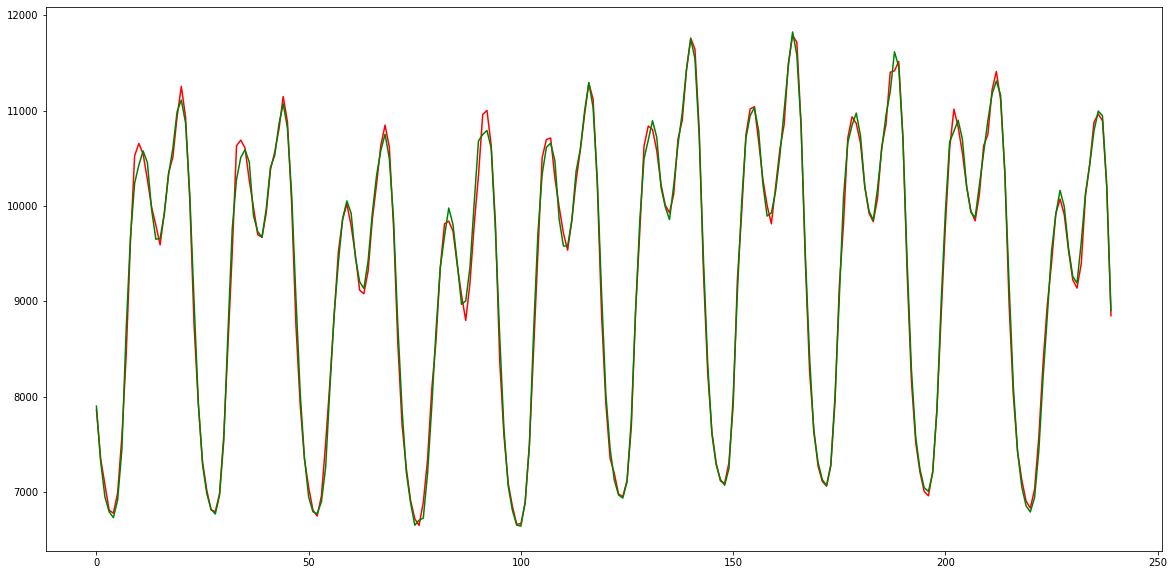

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(load_pred[:240], 'r')
plt.plot(load_true[:240], 'g')

In [32]:
np.save('./load_pred_xgblstm.npy', load_pred)
np.save('./load_true_xgblstm.npy', load_true)
torch.save(model.state_dict(), "xgblstm_state_dict.pt")